In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.neighbors import NearestNeighbors

In [3]:
# Load and preprocess data
def preprocess_data(dataframe):
    # Label encode categorical columns
    le = LabelEncoder()
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        dataframe[col] = le.fit_transform(dataframe[col])

    return dataframe

In [4]:
# Create GNN model
class GNNModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 32)
        self.fc = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x

In [5]:

def create_graph_data(features, k=5):
    # Create k-nearest neighbors graph
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(features)
    distances, indices = knn.kneighbors(features)

    # Create edge indices
    edge_index = []
    for i in range(len(indices)):
        for j in indices[i]:
            if i != j:
                edge_index.append([i, j])

    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()


In [6]:
def plot_confusion_matrices(y_true, y_pred_rf, y_pred_gnn, save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Random Forest confusion matrix
    cm_rf = confusion_matrix(y_true, y_pred_rf)
    sns.heatmap(cm_rf, annot=True, fmt='d', ax=ax1)
    ax1.set_title('Random Forest Confusion Matrix ')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')

    # GNN confusion matrix
    cm_gnn = confusion_matrix(y_true, y_pred_gnn)
    sns.heatmap(cm_gnn, annot=True, fmt='d', ax=ax2)
    ax2.set_title('GNN Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [7]:
def plot_correlation_matrix(data, save_path=None):
    plt.figure(figsize=(10, 8))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    if save_path:
        plt.savefig(save_path)
    plt.show()

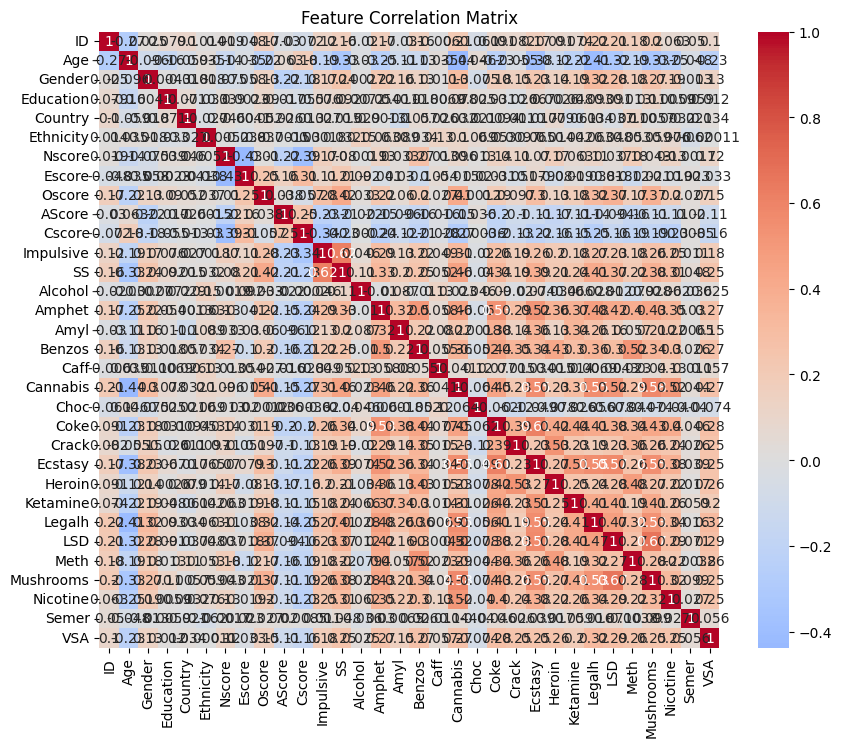

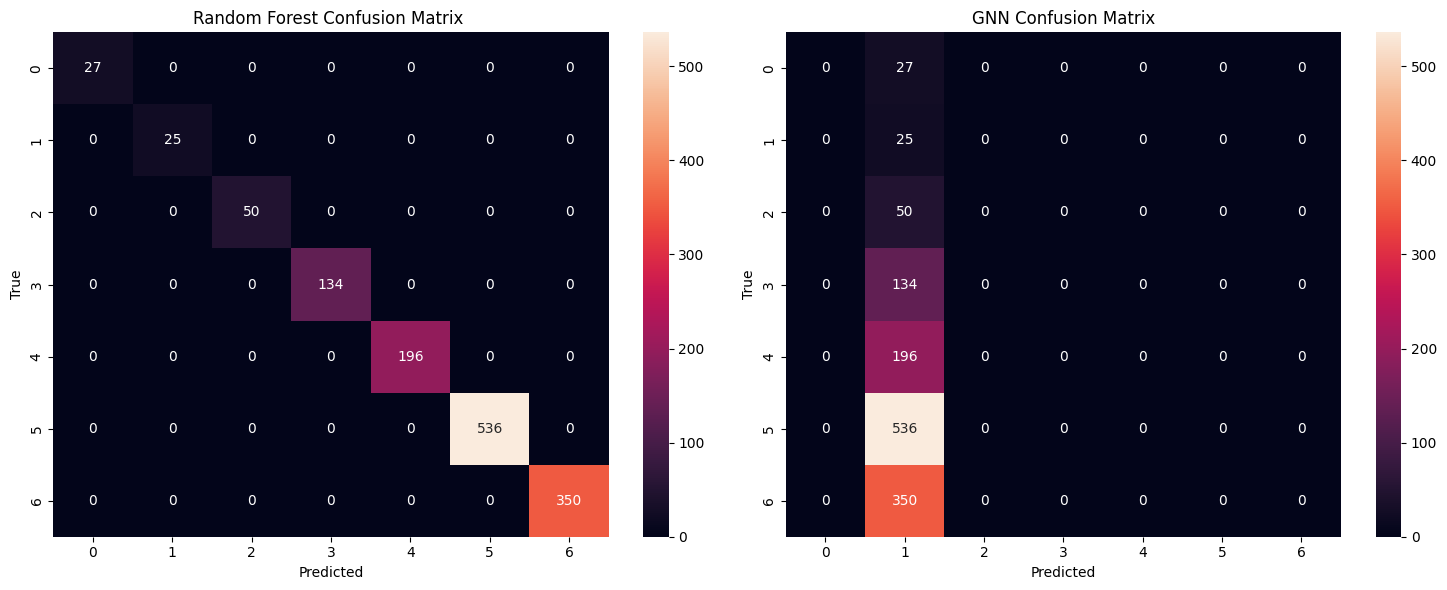


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00       134
           4       1.00      1.00      1.00       196
           5       1.00      1.00      1.00       536
           6       1.00      1.00      1.00       350

    accuracy                           1.00      1318
   macro avg       1.00      1.00      1.00      1318
weighted avg       1.00      1.00      1.00      1318


GNN Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.02      1.00      0.04        25
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00       134
           4       0.00      0.00      0.00       196
           5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


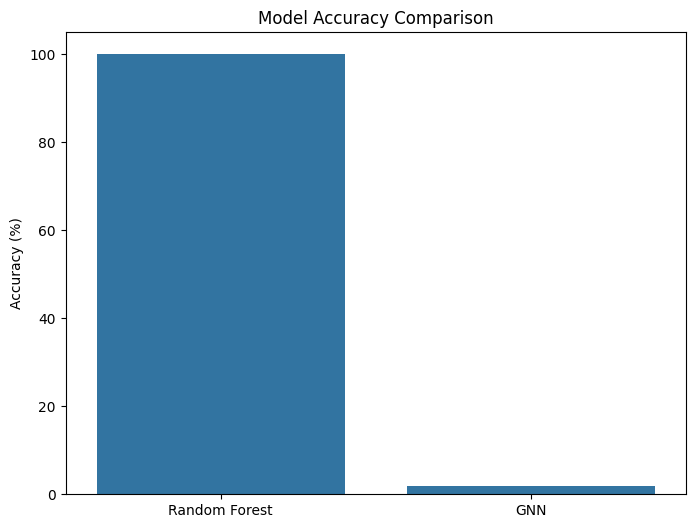

In [8]:
def main():
    # Load data
    dataframe = pd.read_csv("Drug_Consumption.csv")
    dataframe = preprocess_data(dataframe)

    # Plot correlation matrix
    plot_correlation_matrix(dataframe, 'correlation_matrix.png')

    # Prepare data for modeling
    X = dataframe.drop(['Alcohol'], axis=1)
    y = dataframe['Alcohol']

    # Split data but we'll only use training data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_train)  # Predicting on training data

    # GNN
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create graph data
    edge_index = create_graph_data(X_scaled)
    features = torch.tensor(X_scaled, dtype=torch.float)
    labels = torch.tensor(y.values, dtype=torch.float).view(-1, 1)

    # Create train mask only
    train_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[X_train.index] = True

    # Create graph data object
    data = Data(x=features, edge_index=edge_index, y=labels)
    data.train_mask = train_mask
    data = data.to(device)

    # Train GNN
    model = GNNModel(X.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Training loop
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    # Get GNN predictions on training data
    model.eval()
    with torch.no_grad():
        out = model(data)
        gnn_predictions = (torch.sigmoid(out) > 0.5).float().cpu().numpy()

    # Plot confusion matrices for training data
    plot_confusion_matrices(y_train, rf_predictions, gnn_predictions[train_mask], 'confusion_matrices_train.png')

    # Print classification reports for data
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_train, rf_predictions))

    print("\nGNN Classification Report:")
    print(classification_report(y_train, gnn_predictions[train_mask]))

    # Compare model accuracies
    rf_train_accuracy = (rf_predictions == y_train).mean() * 100
    gnn_train_accuracy = (gnn_predictions[train_mask].flatten() == y_train.values).mean() * 100

    # Plot accuracy comparison
    plt.figure(figsize=(8, 6))
    sns.barplot(x=['Random Forest', 'GNN'], y=[rf_train_accuracy, gnn_train_accuracy])
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy (%)')
    plt.savefig('training_accuracy_comparison.png')
    plt.show()

if __name__ == "__main__":
    main()